<a href="https://colab.research.google.com/github/PravinMuraliDharan/Data_Science_Capstone_Project/blob/Master/Emotion_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b> Content

---

- [Packages](#1)
- [Data Wrangling](#2)
  - [Importing and Loading Dataset](#2-1)
  - [Dataset Description](#2-2)
  - [Training Dataset Inspection](#2-3)
  - [Testing Dataset Inspection](#2-4)
- [Data Preprocessing](#3)
  - [Data Augumentation](#3-1)
    - [Data Augumentation Modelling](#3-1.1)
    - [Data Augumentation Implementation](#3-1.2)
- [Predictive Analytics - Deep Learning (CNN)](#4)
  - [Vinnet - Modelling](#4-1)
  - [Vinnet - Model Visualization](#4-2)
  - [Vinnet - Model Call Back Functions](#4-3)
  - [Vinnet - Model Training](#4-4)
  - [Vinnet - Model Performance Visualization](#4-5)
  - [Vinnet - Model Evaluation](#4-6)
    - [Training set Evaluation](#4-6.1)
    - [Testing set Evaluation](#4-6.2)
    - [Storing Optimal Weights of Vinnet Model](#4-6.3)

<a name = '5'></a>
# <b> Packages

---
> Necessary Libraries for performing analysis and implementation of Emotion Classifier using Deep Learning


In [1]:
# Libraries for Data Manupulation
import os
import datetime
import numpy as np
import pandas as pd
import seaborn as sns

# Libraries for Data Visualization
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from mlxtend.plotting import plot_confusion_matrix

# Libraries for Data Preprocessing
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,load_img

# Libraries for Train Test Split
from sklearn.model_selection import train_test_split

# Libraries for Deep Learning
import tensorflow as tf
from keras import layers
from keras.models import Model
from keras.layers import Input
from keras.models import Sequential
from keras.layers import MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Dense , Activation , Dropout ,Flatten

# Libraries for Normalizing
from keras.layers import BatchNormalization

# Libraries for Evaluating the model
from keras import regularizers
from keras.models import model_from_json
from keras.metrics import categorical_accuracy
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau,CSVLogger, TensorBoard

# Library to suppress warnings
import warnings
warnings.filterwarnings('ignore')

print('All libraries are imported Successfully :)')

All libraries are imported Successfully :)


# <b> GPU - Testing

In [2]:
# GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

In [3]:
device_name

'/device:GPU:0'

In [4]:
! nvidia-smi

Fri Sep 24 09:15:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    56W / 149W |    122MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.7193184669999937
GPU (s):
0.04500243999999043
GPU speedup over CPU: 82x


<a name = '2'></a>
# <b> Data Wrangling

---
> It involves preparing dataset such as Data Augumentation and Data Engineering.


<a name = '2-1'></a>
## <b> Importing and Loading Dataset

In [7]:
# Reading the dataset from drive
train_dir = '/content/drive/MyDrive/Colab Notebooks/AlmaBetter/2. Capstone Project/5.Deep Learning/FER-Datasets/train/'
test_dir = '/content/drive/MyDrive/Colab Notebooks/AlmaBetter/2. Capstone Project/5.Deep Learning/FER-Datasets/test/'

In [8]:
# Function to read the dataset
def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df

In [9]:
# Loading the dataset
train_df = count_exp(train_dir, 'train')
test_df = count_exp(test_dir, 'test')

<a name='2-2'></a>
## <b> Dataset Description

---
> The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image.
>
> The task is to categorize each face based on the emotion shown in the facial expression in to one of Seven categories.
> * 0	Happy
> * 1	Angry
> * 2	Surprise
> * 3	Sad
> * 4	Neutral
> * 5 Fear
> * 6 Disgust
>
> We define a simple CNN model and compare the predicted results with ge given labels.


<a name = '2-3'></a>
## <b> Training Dataset Inspection

In [10]:
# Looking into the training data
print(train_df)

       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4965  4830      3171


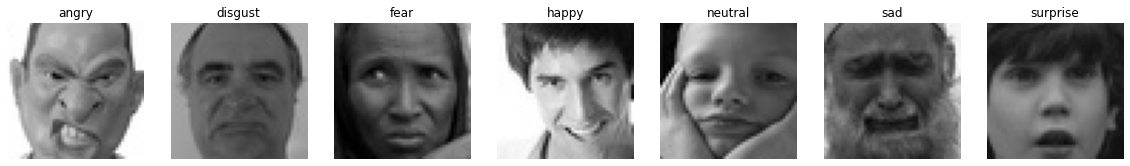

In [11]:
# Visualizing the train dataset
plt.figure(figsize=(20,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

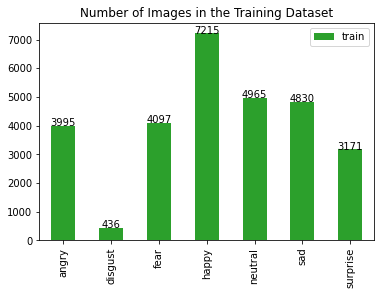

<Figure size 2160x864 with 0 Axes>

In [12]:
# Looking at the distribution of training dataset
ax = train_df.transpose().plot(kind='bar',color='tab:green')
plt.title('Number of Images in the Training Dataset', fontsize=12)
plt.figure(figsize=(30,12))
for i in ax.patches:
    height = i.get_height()
    width = i.get_width()
    ax.text(i.get_x() + width/2, height + 1,height ,ha="center")

<a name = '2-4'></a>
## <b> Testing Dataset Inspection

In [13]:
# Looking into the testing data
print(test_df)

      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


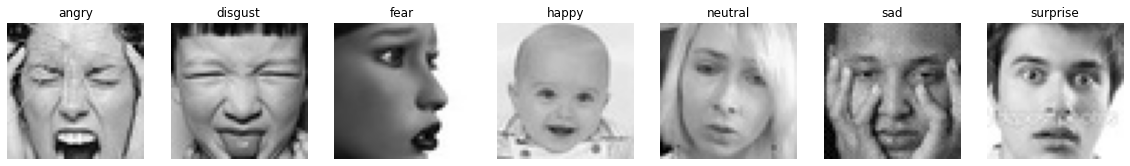

In [14]:
# Visualizing the test dataset
plt.figure(figsize=(20,22))
i = 1
for expression in os.listdir(test_dir):
    img = load_img((test_dir + expression +'/'+ os.listdir(test_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

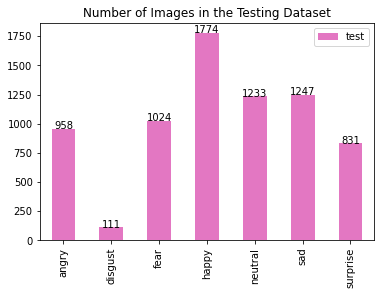

<Figure size 2160x864 with 0 Axes>

In [15]:
# Looking at the distribution of testing dataset
ax = test_df.transpose().plot(kind='bar',color='tab:pink')
plt.title('Number of Images in the Testing Dataset', fontsize=12)
plt.figure(figsize=(30,12))
for i in ax.patches:
    height = i.get_height()
    width = i.get_width()
    ax.text(i.get_x() + width/2, height + 1,height ,ha="center")

<a name = '3'></a>
# <b> Data Preprocessing

In [16]:
# Inputs for data preprocessing
num_of_classes = 7
img_rows,img_cols = 48,48
batch_size = 64

<a name = '3-1'></a>
## <b> Data Augumentation

---
> Data augmentation in data analysis are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data. 
>
>It acts as a regularizer and helps reduce overfitting when training a machine learning model. It is closely related to oversampling in data analysis.


<a name = '3-1.1'></a>
### <b> Data Augumentation Modelling

In [17]:
# Applying ImageDataGenerator method for data augumentation on train set
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3,
					                         horizontal_flip=True)

In [18]:
# Applying ImageDataGenerator method for data augumentation on test set
validation_datagen = ImageDataGenerator(rescale=1./255)

<a name = '3-1.2'></a>
### <b> Data Augumentation Implementation

In [19]:
# Implementing flow from directory method on training set
train_gen = train_datagen.flow_from_directory(train_dir,color_mode='grayscale',
				                                      target_size=(img_rows,img_cols),
				                                      batch_size=batch_size,
				                                      class_mode='categorical',
				                                      shuffle=True)

Found 28709 images belonging to 7 classes.


In [20]:
# Implementing flow from directory method on testing set
valid_gen = validation_datagen.flow_from_directory(test_dir,color_mode='grayscale',
							                                     target_size=(img_rows,img_cols),
							                                     batch_size=batch_size,
							                                     class_mode='categorical',
							                                     shuffle=True)

Found 7178 images belonging to 7 classes.


In [21]:
# Looking at training set classes
train_gen.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [22]:
# Looking at testing set classes
valid_gen.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

<a name = '4'></a>
# <b> Predictive Analytics - Deep Learning (CNN)

---
> Predictive analytics is the use of advanced analytic techniques that leverage historical data to uncover real-time insights and to predict future events. 
>
> The use of predictive analytics is a key milestone on your analytics journey — a point of confluence where classical statistical analysis meets the new world of artificial intelligence (AI).
> 
> Predictive analytics can help you transform the way your business operates


<a name = '4-1'></a>
## <b> Vinnet - Modelling

In [23]:
# Modelling of convolutional neural networks
def cnn_model(num_classes, rows, cols):
  model = Sequential()

# Block - 1
  model.add(Conv2D(64, kernel_size=(3,3),padding='same',activation='relu', input_shape=(rows, cols, 1)))
  model.add(Conv2D(64, kernel_size=(3,3), padding='same',activation='relu'))
  model.add(BatchNormalization())

# Block - 2
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(BatchNormalization())

# Block - 3
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(BatchNormalization())

# Block - 4
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(BatchNormalization())

# Block - 5
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2), strides = (2,2)))

# Block - 6
  model.add(Flatten())
  model.add(Dense(4096, activation='relu'))
  model.add(Dense(2048, activation='relu'))
  model.add(BatchNormalization())
  

# Block - 7
  model.add(Dense(2048, activation='relu'))
  model.add(Dense(1024, activation='relu'))
  model.add(BatchNormalization())
  

# Block - 8
  model.add(Dense(num_classes,activation = 'softmax'))

# Model Compile
  model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001, decay=1e-6),
              metrics=['accuracy'])


  return model

In [24]:
# Looking at the model summary
vinnet = cnn_model(num_of_classes, img_rows, img_cols)
vinnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 24, 24, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

<a name='4-2'></a>
## <b> Vinnet - Model Visualization

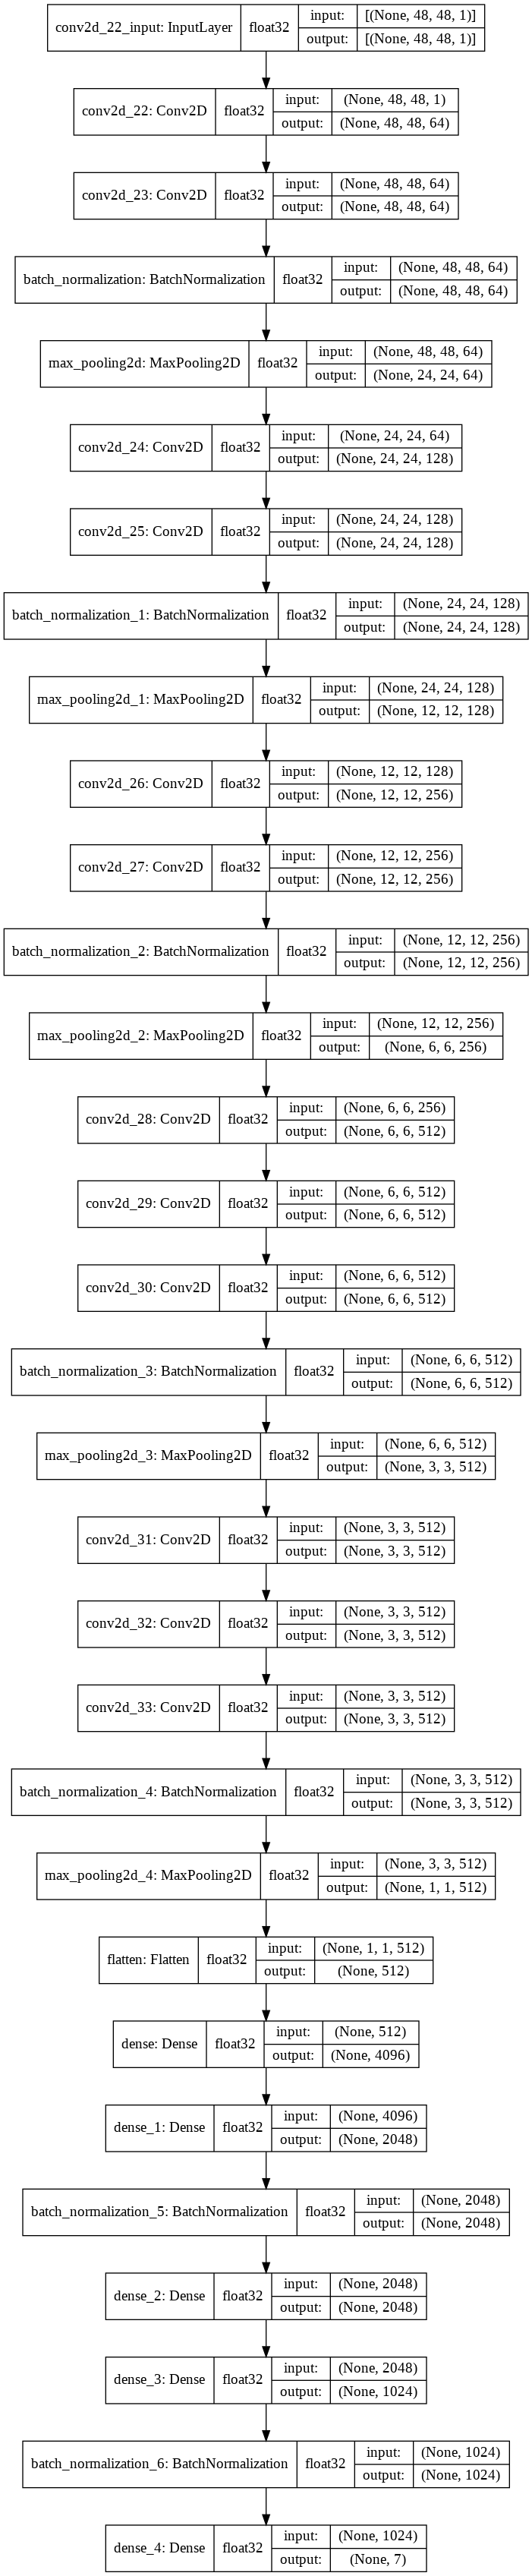

In [25]:
# Visualizing the vinnet model
plot_model(vinnet, to_file='/content/drive/MyDrive/Colab Notebooks/AlmaBetter/2. Capstone Project/5.Deep Learning/FER-Models/vinnet.png', 
           show_shapes=True, show_layer_names=True, show_dtype=True)

<a name = '4-3'></a>
## <b> Vinnet - Model Call Back Functions

In [26]:
# Model call back functions
# Model Checkpoint
file_dir = '/content/drive/MyDrive/Colab Notebooks/AlmaBetter/2. Capstone Project/5.Deep Learning/FER-Models/Vinnet.h5'
checkpoint = ModelCheckpoint(filepath= file_dir,
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

# Model Early Stopping
early_stop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=20,
                          verbose=1,restore_best_weights=True)

# Model Learning Rate Reduction
learn_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.0001)

log_dir = "/content/drive/MyDrive/Colab Notebooks/AlmaBetter/2. Capstone Project/5.Deep Learning/FER-Models/checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, early_stop, learn_reduction, csv_logger]

<a name='4-4'></a>
## <b> Vinnet - Model Training

In [27]:
# Vinnet - Model Training
history = vinnet.fit(x = train_gen,validation_data = valid_gen,epochs=60,
                     callbacks=callbacks,
                     steps_per_epoch=train_gen.n//train_gen.batch_size,
                     validation_steps=valid_gen.n//valid_gen.batch_size)

Epoch 1/60
448/448 [==============================] - 6448s 14s/step - loss: 1.8774 - accuracy: 0.2235 - val_loss: 1.8770 - val_accuracy: 0.2128

Epoch 00001: val_loss improved from inf to 1.87703, saving model to /content/drive/MyDrive/Colab Notebooks/AlmaBetter/2. Capstone Project/5.Deep Learning/FER-Models/Vinnet.h5
Epoch 2/60
448/448 [==============================] - 99s 221ms/step - loss: 1.8331 - accuracy: 0.2353 - val_loss: 1.8212 - val_accuracy: 0.2273

Epoch 00002: val_loss improved from 1.87703 to 1.82120, saving model to /content/drive/MyDrive/Colab Notebooks/AlmaBetter/2. Capstone Project/5.Deep Learning/FER-Models/Vinnet.h5
Epoch 3/60
448/448 [==============================] - 96s 214ms/step - loss: 1.8299 - accuracy: 0.2355 - val_loss: 2.0729 - val_accuracy: 0.2003

Epoch 00003: val_loss did not improve from 1.82120
Epoch 4/60
448/448 [==============================] - 96s 214ms/step - loss: 1.8107 - accuracy: 0.2600 - val_loss: 1.9064 - val_accuracy: 0.2746

Epoch 00004

<a name = '4-5'></a>
## <b> Vinnet - Model Performance Visualization

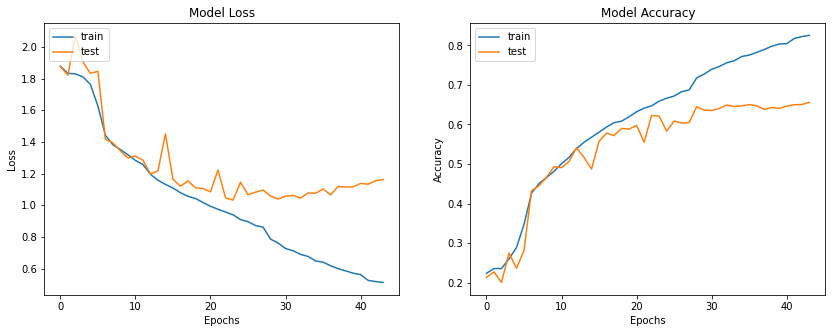

In [28]:
# Plotting the loss and accuracy of vinnet model
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<a name = '4-6'></a>
## <b> Vinnet - Model Evaluation

<a name = '4-6.1'></a>
### <b> Training set Evaluation

In [31]:
# Evaluating Vinnet model training accuracy
print("Evaluate on train data")
results = vinnet.evaluate(train_gen, batch_size=128)
print("train loss, train acc:", results)
print("final train accuracy = {:.2f}".format(results[1]*100))

Evaluate on train data
449/449 [==============================] - 73s 162ms/step - loss: 0.8872 - accuracy: 0.6708
train loss, train acc: [0.8872470855712891, 0.6707652807235718]
final train accuracy = 67.08


<a name = '4-6.2'></a>
### <b> Testing set Evaluation

In [32]:
# Evaluating Vinnet model testing accuracy
print("Evaluate on test data")
predictions = vinnet.evaluate(valid_gen, batch_size=128)
print("test loss, test acc:", predictions)
print("final test accuracy = {:.2f}".format(predictions[1]*100))

Evaluate on test data
113/113 [==============================] - 16s 137ms/step - loss: 1.0328 - accuracy: 0.6209
test loss, test acc: [1.0328047275543213, 0.6209250688552856]
final test accuracy = 62.09


<a name = '4-6.3'></a>
### <b> Storing Optimal Weights of Vinnet Model

In [33]:
# Storing the optimal weights of the vinnet model
file_dir = '/content/drive/MyDrive/Colab Notebooks/AlmaBetter/2. Capstone Project/5.Deep Learning/FER-Models/Optimal_Model/vinnetOptimalmodel.h5'
vinnet.save_weights(file_dir)